In [40]:
import pandas as pd ; import numpy as np ; import matplotlib.pyplot as plt ; import tensorflow as tf ; from sklearn.preprocessing import RobustScaler ; from sklearn.metrics import mean_squared_error, r2_score ; from tensorflow.keras.models import Sequential ; from tensorflow.keras.layers import LSTM, Dense ; from tensorflow.keras.models import load_model

In [41]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = [] # 독립변수 저장
    labels = [] # 종속변수 저장

    start_index = start_index + history_size
    if end_index is None: # 검증 데이터 분할 할 때, end_index를 None으로 지정(즉, 데이터셋 끝까지 추출하겠다는 의미)
        # 데이터셋 내에 더이상 타겟 값으로 사용할 미래 데이터가 없기 때문에 미래 시간만큼 차감
        end_index = len(dataset) - target_size
    # ex) start_index = 0, history_size = 720
    for i in range(start_index, end_index): # (720, 300000)
        indexes = range(i - history_size, i, step) # 1st data indexes: range(720-720, 720, 6)
        data.append(dataset[indexes])

        if single_step:
            labels.append(target[i+target_size]) # target[720+72] -> 12시간 후의 기온 예측
        else: # 미래의 연속된 구간의 기온 예측
            labels.append(target[i:i+target_size]) # target[720:720+72] -> 12시간 동안의 기온 예측

    return np.array(data), np.array(labels)

In [42]:
def plot_train_history(history, title) :
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epoch = range(len(loss))
    plt.plot(epoch, loss, 'b', label='Traing loss')
    plt.plot(epoch, val_loss, 'r', label='Val loss')
    plt.legend()
    plt.title(title)
    plt.show()

In [43]:
# 그래프의 x축 좌표 값 생성
def create_time_steps(length):
    return list(range(-length, 0))

# plot_data: [5일간 기온 데이터, 12시간 후 기온 데이터, 예측 값]
# delta: 미래 예측 지점
# title: 그래프 제목
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    plt.figure(figsize=(12,6))
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.axis('auto')
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [44]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    # history[:, 1] : 3개의 독립변 수 중 2번째 컬럼이 기온 데이터
    plt.plot(num_in, np.array(history[:,1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b:o', label='True Future')
    if prediction.any(): # 값이 있으면...
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r:o', label='Predicted Future')
    plt.legend()
    plt.show()

In [45]:
df = pd.read_excel('(미국일본)김밥&김_관심도수출량수출액_수정.xlsx')

In [46]:
df.head(3)

,Unnamed: 0,kimbap: (미국)_관심도_웹,seaweed: (미국)_관심도_웹,kimbap: (미국)_관심도_유튜브,seaweed: (미국)_관심도_유튜브,キンパ: (일본)_관심도_웹,のり: (일본)_관심도_웹,キンパ: (일본)_관심도_유튜브,のり: (일본)_관심도_유튜브,수출(중량),수출(금액),수입(중량),수입(금액),성장률
0,2007-02-01,0,12,0,0,0,26,0,0,500432.0,4465136,0.0,0,0.86
1,2007-03-01,1,12,0,0,0,22,0,0,524228.8,4351639,1978.0,41283,0.97
2,2007-04-01,0,14,0,0,0,23,0,0,627037.5,4601312,3216.0,29886,1.05


In [47]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the specific scalers for each column
one_scaler = RobustScaler()
two_scaler = RobustScaler()
three_scaler = RobustScaler()
four_scaler = RobustScaler()
five_scaler = RobustScaler()

# Apply the scalers to the respective columns
scaled_data = {
    'seaweed: (미국)_관심도_웹': one_scaler.fit_transform(df[['seaweed: (미국)_관심도_웹']]).flatten(),
    'kimbap: (미국)_관심도_웹': two_scaler.fit_transform(df[['kimbap: (미국)_관심도_웹']]).flatten(),
    'キンパ: (일본)_관심도_웹': three_scaler.fit_transform(df[['キンパ: (일본)_관심도_웹']]).flatten(),
    'kimbap: (미국)_관심도_유튜브': four_scaler.fit_transform(df[['kimbap: (미국)_관심도_유튜브']]).flatten(),
    '수출(금액)': five_scaler.fit_transform(df[['수출(금액)']]).flatten()
    }
# Combine the scaled columns back into a dataframe
scaled_selected_df = pd.DataFrame(scaled_data, columns=scaled_data.keys())
scaled_selected_df['Unnamed: 0'] = df['Unnamed: 0']

In [48]:
scaled_selected_df.set_index('Unnamed: 0', inplace=True)

In [49]:
scaled_selected_df.head(3)

,seaweed: (미국)_관심도_웹,kimbap: (미국)_관심도_웹,キンパ: (일본)_관심도_웹,kimbap: (미국)_관심도_유튜브,수출(금액)
Unnamed: 0,,,,,
2007-02-01,-0.851064,-1.0,-0.333333,0.0,-0.602371
2007-03-01,-0.851064,0.0,-0.333333,0.0,-0.605578
2007-04-01,-0.680851,-1.0,-0.333333,0.0,-0.598522


In [50]:
dataset = scaled_selected_df.values

In [51]:
TRAIN_SPLIT = int(len(scaled_selected_df)*0.8) 
past_history = 12
future_target = 12
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, target=dataset[:,-1], start_index=0, end_index=TRAIN_SPLIT, history_size=past_history, target_size=future_target, step=STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, target=dataset[:,-1], start_index=TRAIN_SPLIT, end_index=None, history_size=past_history, target_size=future_target, step=STEP, single_step=False)

In [52]:
BATCH_SIZE = 8 ; EPOCH = 100  ; BUFFER_SIZE = 10000 ; STEPS_PER_EPOCH = len(x_train_multi) / BATCH_SIZE 

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()


val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()

In [53]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64, input_shape=x_train_multi.shape[-2:], return_sequences=True))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(12))
multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCH, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_data_multi, validation_steps=5)

Epoch 1/100
19/19 [==============================] - 8s 96ms/step - loss: 0.3227 - val_loss: 0.8169
Epoch 2/100
19/19 [==============================] - 0s 11ms/step - loss: 0.2398 - val_loss: 0.6892
Epoch 3/100
19/19 [==============================] - 0s 10ms/step - loss: 0.2076 - val_loss: 0.6362
Epoch 4/100
19/19 [==============================] - 0s 10ms/step - loss: 0.1894 - val_loss: 0.5946
Epoch 5/100
19/19 [==============================] - 1s 74ms/step - loss: 0.1834 - val_loss: 0.5599
Epoch 6/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1710 - val_loss: 0.5149
Epoch 7/100
19/19 [==============================] - 0s 10ms/step - loss: 0.1647 - val_loss: 0.4946
Epoch 8/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1557 - val_loss: 0.5171
Epoch 9/100
19/19 [==============================] - 0s 10ms/step - loss: 0.1503 - val_loss: 0.4641
Epoch 10/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1411 - val_loss: 0.3647

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_multi.shape[-2:],return_sequences=True)) # TensorShape : [256,120,3]
# 싱글 스텝 예측보다는 복잡하기 때문에 LSTM을 두 개의 층으로 구성
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
# 미래의 3달 동안의 온도를 예측해야 해서 출력값을 3로 설정
multi_step_model.add(tf.keras.layers.Dense(12))
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss = 'mae')

# validation_steps : 1 epoch에서 이뤄질 검증 횟수
# stpes_per_epoch : 1 epoch에서 사용할 batch의 갯수
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCH, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_data_multi, validation_steps=5)

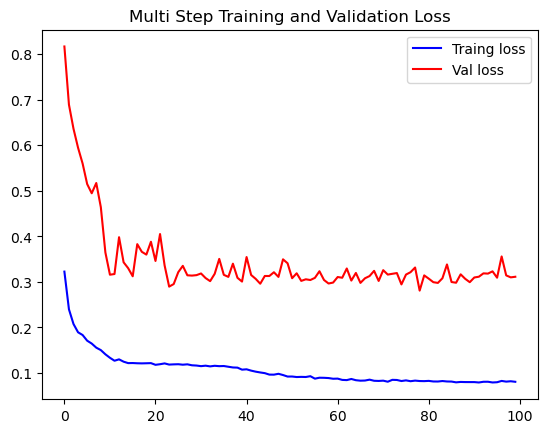

In [54]:
plot_train_history(multi_step_history, 'Multi Step Training and Validation Loss')

In [55]:
y_hat = multi_step_model.predict(val_data_multi, steps=12)

12/12 [==============================] - 2s 4ms/step


In [56]:
for x,y in val_data_multi.take(3) :
    print(x.shape, y.shape)

(8, 12, 5) (8, 12)
(8, 12, 5) (8, 12)
(8, 12, 5) (8, 12)


1/1 [==============================] - 2s 2s/step


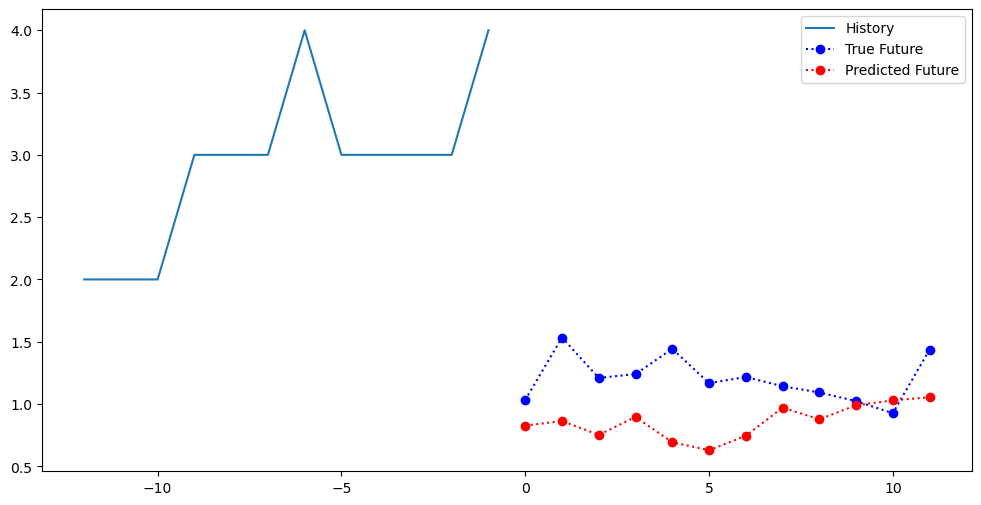

tf.Tensor(
[1.03207685 1.53381995 1.20925615 1.2401951  1.44322784 1.16747281
 1.21708543 1.14265723 1.09269277 1.02352794 0.92586068 1.43651731], shape=(12,), dtype=float64)
1/1 [==============================] - 0s 30ms/step


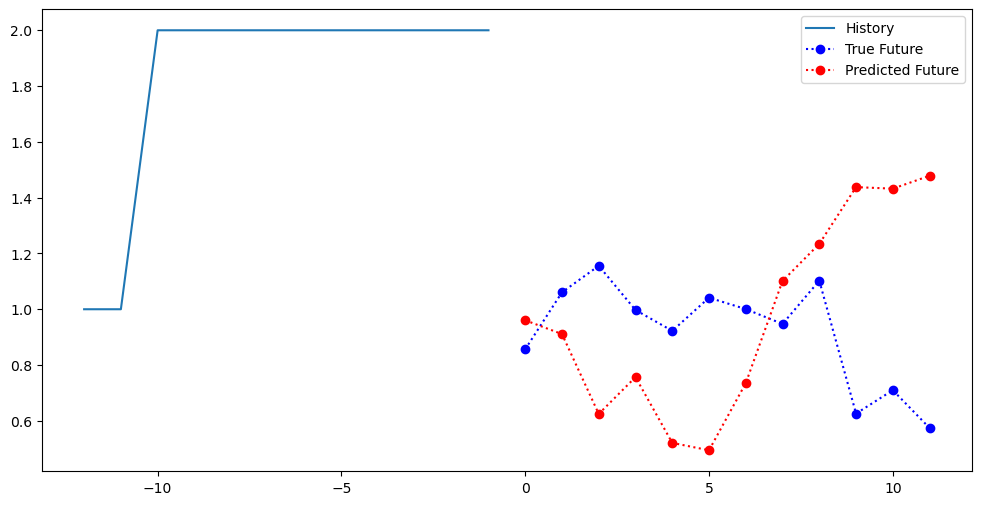

tf.Tensor(
[0.85670136 1.06067813 1.15570885 0.99719298 0.92249284 1.04144416
 1.00053412 0.94734847 1.10248696 0.62595868 0.7098664  0.57426641], shape=(12,), dtype=float64)
1/1 [==============================] - 0s 35ms/step


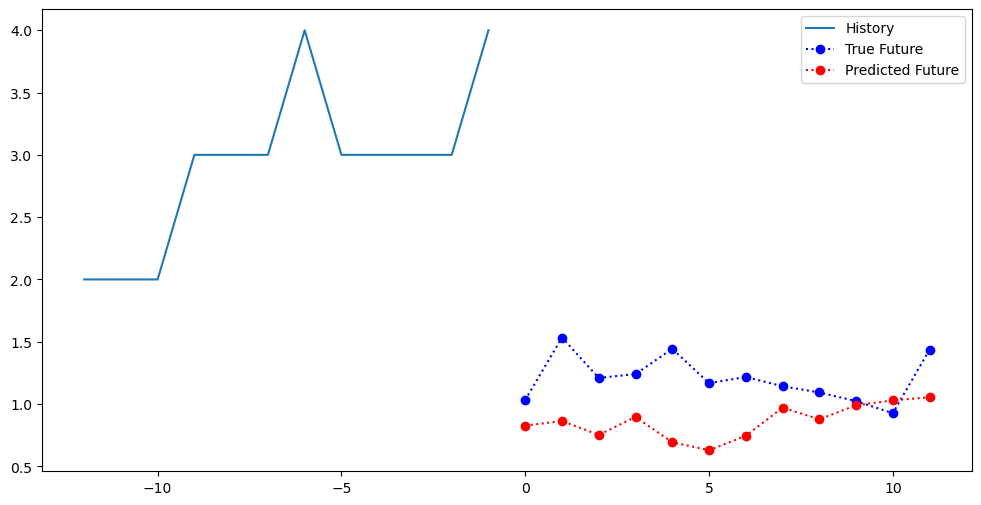

tf.Tensor(
[1.03207685 1.53381995 1.20925615 1.2401951  1.44322784 1.16747281
 1.21708543 1.14265723 1.09269277 1.02352794 0.92586068 1.43651731], shape=(12,), dtype=float64)


In [57]:
for x, y in val_data_multi.take(3) :
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
    print(y[0])
    plt.show()

In [58]:
y_hat[-1]

array([0.81927836, 0.8335511 , 0.69764197, 0.86512685, 0.67781365,
       0.6438732 , 0.81960976, 1.0885804 , 0.9902247 , 1.0853577 ,
       1.108504  , 1.0935786 ], dtype=float32)

In [60]:
x = five_scaler.inverse_transform(y_hat[-1].reshape(-1,1))

In [61]:
x

array([[54766332.],
       [55271332.],
       [50462556.],
       [56388556.],
       [49760984.],
       [48560096.],
       [54778056.],
       [64294852.],
       [60814804.],
       [64180824.],
       [64999800.],
       [64471700.]], dtype=float32)